Importing Libraries

In [ ]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
from tensorflow import keras
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

Data Preprocessing

In [16]:
def get_data():
    iris_data = pd.read_csv("Data.csv")

    label_encoder = preprocessing.LabelEncoder()
    iris_data['Species'] = label_encoder.fit_transform(iris_data['Species'])

    np_iris= iris_data.to_numpy()

    X_data = np_iris[: , : 4]
    Y_data = np_iris[: , 4]

    scaler = StandardScaler().fit(X_data)
    X_data = scaler.transform(X_data)

    Y_data = tf.keras.utils.to_categorical(Y_data,3)
    return X_data, Y_data

Model Configuration

Separates architecture/config choices (like optimizer, layers, dropout, etc.) from logic. This makes experiments easier to run by tweaking config values.

In [17]:
def base_model_config():
    model_config = {
        "HIDDEN_NODES": [32, 64],
        "HIDDEN_ACTIVATION": "relu",
        "OUTPUT_NODES": 3,
        "OUTPUT_ACTIVATION": "softmax",
        "WEIGHTS_INITIALIZER": "random_normal",
        "BIAS_INITIALIZER": "zeros",
        "NORMALIZATION": "none",
        "OPTIMIZER": "rmsprop",
        "LEARNING_RATE": 0.001,
        "REGULARIZER": None,
        "DROPOUT_RATE": 0.0,
        "EPOCHS": 10,
        "BATCH_SIZE": 16,
        "VALIDATION_SPLIT": 0.2,
        "VERBOSE": 0,
        "LOSS_FUNCTION": "categorical_crossentropy",
        "METRICS": ["accuracy"]
    }
    return model_config

Utility Functions

Helper functions so that optimizers & regularizers are passed as keras objects instead of strings

In [18]:
def get_optimizer(optimizer_name, learning_rate):
    if optimizer_name == 'adagrad':
        return keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        return keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'adam':
        return keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        return keras.optimizers.SGD(learning_rate=learning_rate)
    
def get_regularizer(regularizer_name):
    if regularizer_name =='l1':
        return keras.regularizers.l1()
    elif regularizer_name == 'l2':
        return keras.regularizers.l2()
    elif regularizer_name == 'l1_l2':
        return keras.regularizers.l1_l2(l1=0.01, l2=0.01)
    else:
        return None

Model Creation and Training

In [22]:
def create_and_run_model(model_config, X, Y, model_name):
    model = tf.keras.models.Sequential(name=model_name)

    # Hidden Layers

    for i, units in enumerate(model_config["HIDDEN_NODES"]):
        if i==0:
            model.add(keras.layers.Dense(units, input_shape=(X.shape[1], ), name=f"Dense-Layer-{i}",
                                         activation=model_config["HIDDEN_ACTIVATION"], 
                                         kernel_initializer=model_config["WEIGHTS_INITIALIZER"], 
                                         bias_initializer=model_config["BIAS_INITIALIZER"], 
                                         kernel_regularizer=model_config["REGULARIZER"]))
    
        else:
            if model_config["NORMALIZATION"] == "batch":
                model.add(keras.layers.BatchNormalization())

            if model_config["DROPOUT_RATE"] > 0.0:
                model.add(keras.layers.Dropout(model_config["DROPOUT_RATE"]))

            model.add(keras.layers.Dense(units,
                                         name=f"Dense-Layer-{i}",
                                         activation=model_config["HIDDEN_ACTIVATION"],
                                         kernel_initializer=model_config["WEIGHTS_INITIALIZER"],
                                         bias_initializer=model_config["BIAS_INITIALIZER"],
                                         kernel_regularizer=model_config["REGULARIZER"]))
            
    # Output Layer

    model.add(keras.layers.Dense(model_config["OUTPUT_NODES"], 
                                 name="Output_Layer",
                                 activation=model_config["OUTPUT_ACTIVATION"]))
    
    # Compile

    optimizer = get_optimizer(model_config["OPTIMIZER"], model_config["LEARNING_RATE"])
    model.compile(loss=model_config["LOSS_FUNCTION"], optimizer=optimizer, metrics=model_config["METRICS"])

    print("\n================== MODEL SUMMARY ==================")
    model.summary()

    # Split data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=model_config["VALIDATION_SPLIT"])

    # Train Model

    history = model.fit(X_train, Y_train, 
                        batch_size=model_config["BATCH_SIZE"], 
                        epochs=model_config["EPOCHS"], 
                        verbose=model_config["VERBOSE"], 
                        validation_data=(X_test, Y_test))
    return history                                                           

Plotting Accuracy Over Epochs

In [23]:
def plot_graph(accuracy_measures, title):
    plt.figure(figsize=(15, 10))
    for experiment in accuracy_measures.keys():
        plt.plot(accuracy_measures[experiment], label= experiment, linewidth=3)

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

Final Main Runner


================== MODEL SUMMARY ==================


C:\Users\Lisha Angral\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Iris_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)

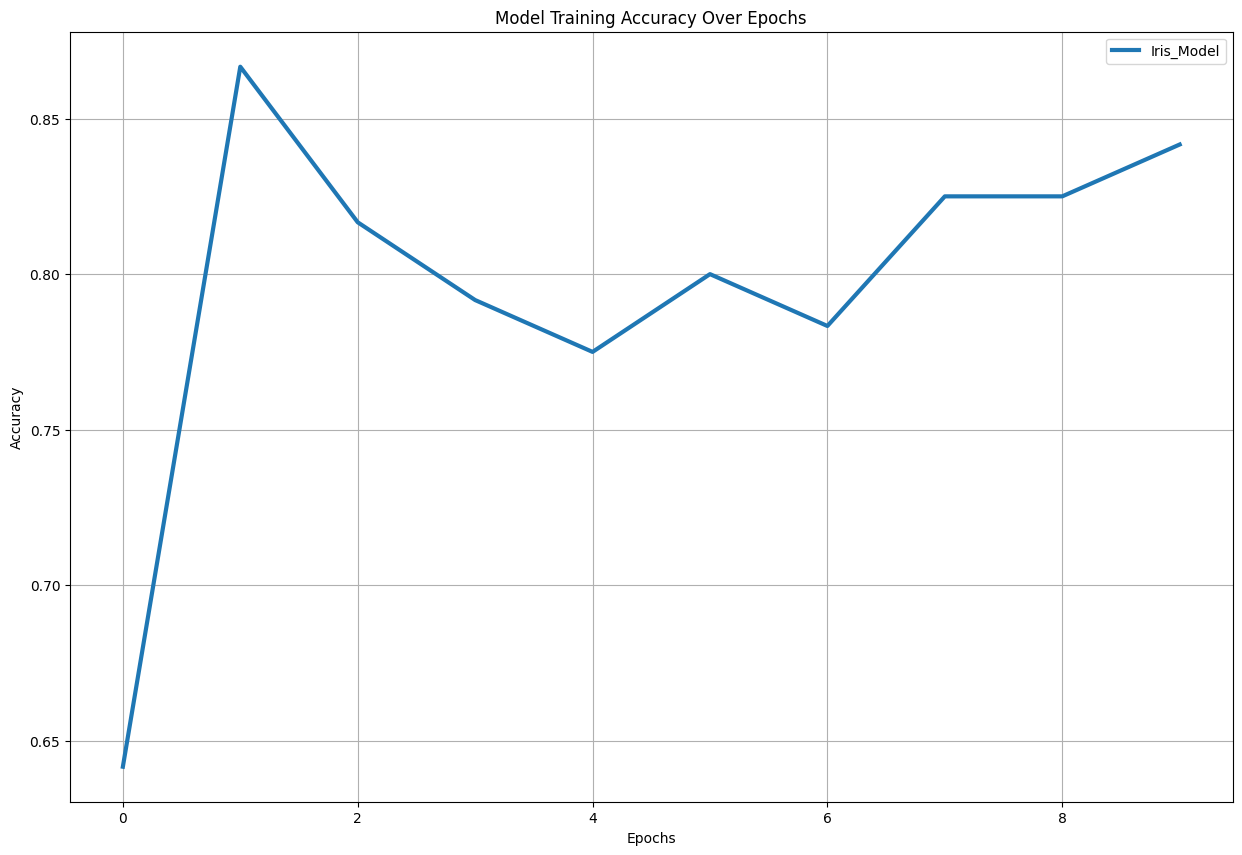

In [24]:
if __name__ == "__main__":
    X_data, Y_data = get_data()
    config = base_model_config()
    history = create_and_run_model(config, X_data, Y_data, "Iris_Model")
    plot_graph({"Iris_Model": history.history["accuracy"]}, "Model Training Accuracy Over Epochs")